# Demonstrate accessing UM DYAMOND3 simulations from zarr on JASMIN object store: v5 version

### 24/4/25

* **Third look at simulations for WCRP Hackathon UK Node. v5 is/will be the final version of the global data**
* **Zoom level 10 (n2560/regional) or 9 (n1280) may not be complete**
* **Stores are not complete: some stores only have first 12 h, glm.n2560_RAL3p3 has most data but processing issues mean time data not contiguous**
* **However these stores will be filled in as the simulation data becomes avialable. We will let other nodes know when they are complete**
* Shows the hierarchy of simulations that will be available at the UK node, from global to regional.
* You can see the URLs which are active in the `cat` catalog.
* Contact mark.muetzelfeldt@reading.ac.uk for more info.

## Simulations

* glm: global model. n1280 is approx. 10 km res (stored at zoom 9), n2560 is 5 km (zoom 10). Regional simulations are at 4.4 km (zoom 10).
* Regional: Africa, South East Asia, South America, Cyclic Tropical Channel
* Settings:
    * CoMA9: CoMorph global,
    * RAL3: Regional Atmosphere Land 3
    * GAL9: Global Atmosphere Land 9
    * RAL3p3: RAL3.3
    * CoMA9_TBv1: CoMA9 TrailBlazer v1

## Technical

* All data stored as healpix, including regional.
* Regional simulations only store active chunks.
* Regional data necessarily has `nan`s to represent data outside the domain. This can cause issues when calculating domain means at different zooms. The `weights` field should help mitigate this (instructions to follow).
* There are two stores for each zoom level, one for `PT1H` (2D) and `PT3H` (3D) variables. All simulations are in the `sims` variable.
* Calling `ds = ds.compute()` downloads the data from JASMIN. This can be slow and/or fail with a server error. Try again if this happens.
* Can be run on JASMIN or anywhere else: call `Catalog(on_jasmin=True)` for JASMIN
* Tested using this Python conda env: https://github.com/digital-earths-global-hackathon/tools/blob/main/python_envs/environment.yaml (with some extra packages).
    * You can install with:
    * `wget https://raw.githubusercontent.com/digital-earths-global-hackathon/tools/refs/heads/main/python_envs/environment.yaml`
    * <edit last line of environment.yaml to be the name of your new env, e.g. hackathon_env>
    * `conda env create -f environment.yaml`
* Not all variables in the standard protocol are present - I have included those that are.
* I believe there is a plotting issue at lon=0 - and that data is OK.

## Issues

* CTC simulations where I think there is a genuine issue at lon=0
* Data not complete at zooms 9-0 (n2560/regional) or 8-0 (n1280), although empty zarr stores are present
* No data for most times for regional
* No zarr store for glm.n1280_CoMA9


In [1]:
import math as maths

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import easygems.healpix as egh

In [2]:
sims = [
    # 'glm.n1280_CoMA9', # currently has no zarr store.
    'glm.n2560_RAL3p3',
    'glm.n1280_GAL9_nest',
    'SAmer_km4p4_RAL3P3.n1280_GAL9_nest',
    'Africa_km4p4_RAL3P3.n1280_GAL9_nest',
    'SEA_km4p4_RAL3P3.n1280_GAL9_nest',
    'SAmer_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'Africa_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'SEA_km4p4_CoMA9_TBv1.n1280_GAL9_nest',
    'CTC_km4p4_RAL3P3.n1280_GAL9_nest',
    'CTC_km4p4_CoMA9_TBv1.n1280_GAL9_nest'
]

In [3]:
class Item:
    def __init__(self, url):
        self.url = url

    def to_dataset(self):
        return xr.open_zarr(self.url)

class Catalog:
    """Really simple Catalog. Checks that args are valid/allowed."""
    def __init__(self, on_jasmin=False):
        if on_jasmin:
            self.url_tpl = 'http://hackathon-o.s3.jc.rl.ac.uk/sim-data/dev/v5/{sim}/um.{freq}.hp_z{zoom}.zarr'
        else:
            self.url_tpl = 'https://hackathon-o.s3-ext.jc.rl.ac.uk/sim-data/dev/v5/{sim}/um.{freq}.hp_z{zoom}.zarr'
        
    allowed_params = {
        'sim': sims,
        'freq': ['PT1H', 'PT3H'],
        'zoom': list(range(11)),
    }
    def __call__(self, **kwargs):
        if 'glm.n1280' in kwargs['sim']:
            if kwargs['zoom'] == 10:
                raise Exception('n1280 has no zoom=10')
            
        for k, v in kwargs.items():
            if k not in self.allowed_params:
                raise Exception(f'Unknown param: {k}, must be one of {self.allowed_params.keys()}')
            if v not in self.allowed_params[k]:
                raise Exception(f'Unallowed param value: {v}, must be one of {self.allowed_params[k]}')
            
        return Item(self.url_tpl.format(**kwargs))

In [4]:
cat = Catalog()
# Show example URL
cat(sim='glm.n1280_GAL9_nest', freq='PT1H', zoom=9).url

'https://hackathon-o.s3-ext.jc.rl.ac.uk/sim-data/dev/v5/glm.n1280_GAL9_nest/um.PT1H.hp_z9.zarr'

In [5]:
# Open a dataset.
ds = cat(sim='glm.n1280_GAL9_nest', freq='PT1H', zoom=9).to_dataset()

In [6]:
# Explore dataset. No data downloaded at this point, only metadata.
ds

<xarray.Dataset> Size: 3TB
Dimensions:  (cell: 3145728, time: 10489)
Coordinates:
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Data variables: (12/24)
    clivi    (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    clt      (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    clwvi    (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    hflsd    (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    hfssd    (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    huss     (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    ...       ...
    rsut     (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    rsutcs   (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    tas      (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    ts       (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    uas      (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    vas      (time, cell) float32 132GB dask.array<chunksize=(4, 262144), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n1280_GAL9_nest

<Figure size 640x480 with 0 Axes>

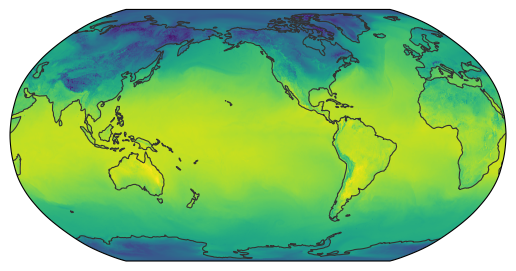

In [7]:
# Quick plot of global T at 1.5m
egh.healpix_show(ds.isel(time=0).tas)

In [8]:
def plot_all_fields(ds_plot):
    """Plot all fields for a given dataset. Assumes that each field is 2D - i.e. sel(time=..., [pressure=...]) has been applied"""
    zoom = int(np.log2(ds_plot.crs.attrs['healpix_nside']))
    projection = ccrs.Robinson(central_longitude=0)
    rows = maths.ceil(len(ds_plot.data_vars) / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(30, rows * 20 / 6), subplot_kw={'projection': projection}, layout='constrained')
    if 'pressure' in ds_plot.coords:
        plt.suptitle(f'{ds.simulation} z{zoom} @{float(ds_plot.pressure)}hPa')
    else:
        plt.suptitle(f'{ds.simulation} z{zoom}')
            
    for ax, (name, da) in zip(axes.flatten(), ds_plot.data_vars.items()):
        time = pd.Timestamp(ds.time.values[0])
    
        if abs(da.max() + da.min()) / (da.max() - da.min()) < 0.5:
            # data looks like it needs a diverging cmap.
            # figure out some nice bounds.
            pl, pu = np.percentile(da.values[~np.isnan(da.values)], [2, 98])
            vmax = np.abs([pl, pu]).max()
            kwargs = dict(
                cmap='bwr',
                vmin=-vmax,
                vmax=vmax,
            )
        else:
            kwargs = {}
        ax.set_title(f'time: {time} - {name}')
        ax.set_global()
        im = egh.healpix_show(da, ax=ax, **kwargs);
        long_name = da.long_name
            
        plt.colorbar(im, label=f'{long_name} ({da.attrs.get("units", "-")})')
        ax.coastlines()

In [9]:
# Download the requested data for plotting.
ds3d = cat(sim='glm.n1280_GAL9_nest', freq='PT3H', zoom=9).to_dataset().sel(time=pd.Timestamp('2020-01-20 03:00'), pressure=500).compute()

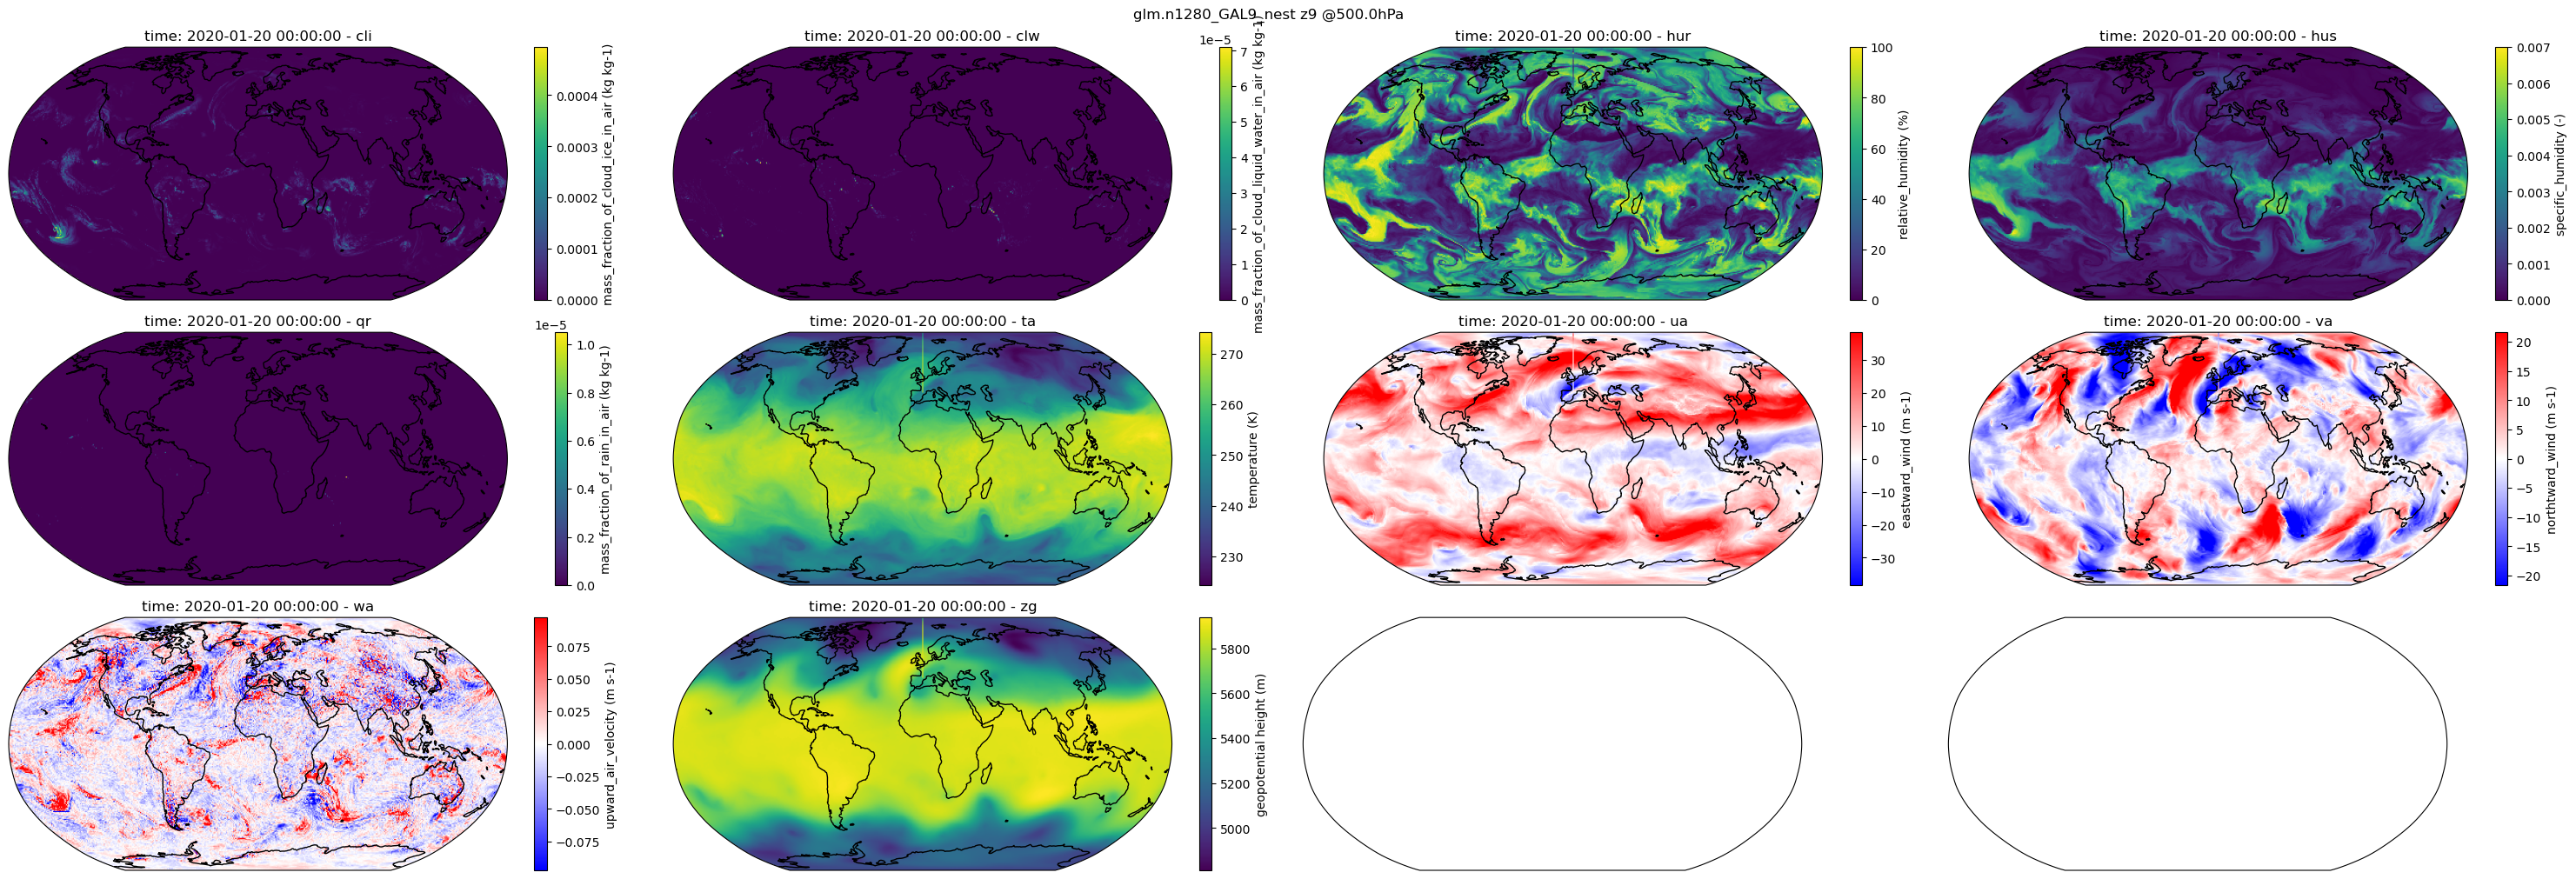

In [10]:
plot_all_fields(ds3d)

In [ ]:
ds2d = cat(sim='glm.n1280_GAL9_nest', freq='PT1H', zoom=9).to_dataset().sel(time=pd.Timestamp('2020-01-20 03:00')).compute()

In [ ]:
plot_all_fields(ds2d)

In [ ]:
ds_africa = cat(sim='Africa_km4p4_CoMA9_TBv1.n1280_GAL9_nest', freq='PT1H', zoom=10).to_dataset().sel(time=pd.Timestamp('2020-01-20 03:00')).compute()

In [ ]:
plot_all_fields(ds_africa)

In [ ]:
# Get dataset for all available sims.
dss = {}
for sim in sims:
    zoom = 9 if 'glm.n1280' in sim else 10
    #zoom = 10
    try:
        dss[sim] = cat(sim=sim, freq='PT1H', zoom=zoom).to_dataset()
    except:
        print(f'Could not load {sim}')

In [ ]:
# Sort to nicer order for plotting.
def sorter(sim):
    if 'glm.n2560' in sim:
        return 'A'
    elif 'glm.n1280' in sim:
        return 'AA'
    else:
        return sim

dss = {s: dss[s] for s in sorted(dss.keys(), key=sorter)}

In [ ]:
def plot_var(plot_dss, var, time, **plot_kwargs):
    """Plot given var from each dataset."""
    rows = maths.ceil(len(plot_dss) / 3)
    projection = ccrs.Robinson(central_longitude=0)
    fig, axes = plt.subplots(rows, 3, figsize=(30, 5 * rows), subplot_kw={'projection': projection}, layout='constrained')
            
    for ax, (name, ds) in zip(axes.flatten(), plot_dss.items()):
        time = pd.Timestamp(ds.time.values[0])
        da = ds[var].sel(time=time).compute()
    
        if abs(da.max() + da.min()) / (da.max() - da.min()) < 0.5:
            # data looks like it needs a diverging cmap.
            # figure out some nice bounds.
            pl, pu = np.percentile(da.values[~np.isnan(da.values)], [2, 98])
            vmax = np.abs([pl, pu]).max()
            kwargs = dict(
                cmap='bwr',
                vmin=-vmax,
                vmax=vmax,
            )
        else:
            kwargs = {}
        kwargs.update(plot_kwargs)
        ax.set_title(f'time: {time} - {name}')
        ax.set_global()
        if ds.attrs['regional']:
            # Display the active chunks for any regional data.
            ds_ones = xr.Dataset({'ones': (['cell'], np.ones_like(ds.isel(time=0).tas))}, coords={'cell': ds.cell}).assign_coords(crs=ds.crs)
            egh.healpix_show(ds_ones.ones, ax=ax)
        im = egh.healpix_show(da, ax=ax, **kwargs);
        long_name = da.long_name
            
        plt.colorbar(im, label=f'{long_name} ({da.attrs.get("units", "-")})')
        ax.coastlines()

In [ ]:
# Display tas/air_temperature for all available sims.
# For regional data, this also shows the active chunks (purply jagged outline). Only active chunks are saved to minimize memory reqs on host computer when loading data.
plot_var(dss, 'tas', pd.Timestamp('2020-01-20 10:00'), vmin=215, vmax=310)